# Introduction

Metadata adata with cell type labels : /home/tchari/metadata/bus_stim.h5ad

Loom file with all cell types (in seawater control only): /home/tchari/counts/clytia_stim/loom/clytia_SWall_allGenes.loom

Script where I made loom files: https://github.com/tarachari3/perturbCME/blob/main/scripts/concatLoomsClytia.py

Notebook where I plot genes that change over development for nematocytes (also called cnidocytes in notebook): https://github.com/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/CellAtlasAnalysis/fullTrajAnalysis.ipynb
concatLoomsClytia.py
<https://github.com/tarachari3/perturbCME|tarachari3/perturbCME>tarachari3/perturbCME | Added by GitHub
fullTrajAnalysis.ipynb

# Preparation

In [1]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import scanpy as sc
import scvelo as scv

In [4]:
def select_genes(U,S,gene_names,mean_min=0.1,var_min=1):
    gene_mask = (np.mean(S,axis=0)>0) & (np.mean(U,axis=0)>0) & (np.var(S,axis=0)>0) & (np.var(U,axis=0)>0)
    s = S[:,gene_mask]
    u = U[:,gene_mask]
    gene_names = gene_names[gene_mask]
    cov = np.cov(u,s,rowvar=False)
    s_mean = np.mean(s,axis=0)
    u_mean = np.mean(u,axis=0)
    X_mean = np.append(u_mean,s_mean)
    p = s.shape[1]
    rho = cov/X_mean[:,None]/X_mean[None,:]
    rho_s = rho[p:,p:]
    rho_u = rho[:p,:p]
    rho_us = rho[:p,p:]
    s = (np.sum(rho_us)-np.sum(np.diag(rho_us)))/(p-1)/p
    genes_mask = (s_mean>mean_min) & (u_mean>mean_min) & (np.abs(np.diag(rho_us)-s)>var_min)
    return gene_names[genes_mask]

## Load data

In [194]:
metafile = "/home/tchari/metadata/bus_stim.h5ad"
loomfile = "/home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom"
loomfile = "/home/tchari/counts/clytia_stim/loom/clytia_SW_KClNematocyte.loom"
metadata = sc.read(metafile)
adata = sc.read(loomfile)

In [195]:
adata

AnnData object with n_obs × n_vars = 2238 × 45872
    obs: 'Barcode'
    layers: 'matrix', 'spliced', 'unspliced'

In [180]:
metadata.obs

,batch,n_counts,n_countslog,louvain,condition,orgID,cellRanger_louvain,annos,annosSub
index,,,,,,,,,
AAACCCAAGAGCGACT-1,0,2423.0,3.384353,5,SW,3,1,Epidermal/Muscle,Exumbrella Epidermis
AAACCCAAGGCTCACC-1,0,10179.0,4.007705,1,DI,6,6,Neural,Neural Cells Early Stages
AAACCCAAGGGTACAC-1,0,17855.0,4.251760,1,KCl,11,11,Nematocyte,Early Nematocytes
AAACCCACACATGAAA-1,0,1830.0,3.262451,5,KCl,11,21,Nematocyte,Mechanosensory Cells-B
AAACCCACACCCTAAA-1,0,3852.0,3.585686,7,KCl,11,24,Gastroderm,GastroDigestive-F
...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGGAGGTG-2,1,2633.0,3.420451,3,DI,5,7,Gastroderm,GastroDigestive-B
TTTGTTGAGTGTTCCA-2,1,11215.0,4.049799,12,SW,3,15,Gastroderm,GastroDigestive-D
TTTGTTGGTCCCTAAA-2,1,5748.0,3.759517,1,DI,8,11,Nematocyte,Early Nematocytes


In [197]:
meta_mask = (metadata.obs["condition"].isin(["KCl","SW"]) ) & (metadata.obs["annos"] == "Nematocyte")
print(np.sum(meta_mask))
adata.obs["annos"] = metadata.obs["annos"][meta_mask]
adata.obs["annosSub"] = metadata.obs["annosSub"][meta_mask]
adata.obs["louvain"] = metadata.obs["louvain"][meta_mask]
adata.obsm["X_pca"] = metadata.obsm["X_pca"][meta_mask]
adata.obsm["X_tsne"] = metadata.obsm["X_tsne"][meta_mask]
adata.obsm["X_umap"] = metadata.obsm["X_umap"][meta_mask]
adata

2238


AnnData object with n_obs × n_vars = 2238 × 45872
    obs: 'Barcode', 'annos', 'annosSub', 'louvain'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

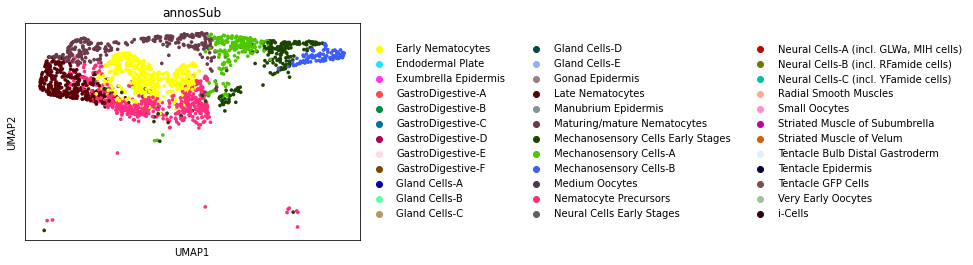

In [198]:
sc.pl.umap(adata,color=["annosSub"])

## Select cells

In [199]:
celltypes = ['Nematocyte Precursors','Early Nematocytes','Late Nematocytes','Maturing/mature Nematocytes','i-Cells']
cell_mask = adata.obs["annosSub"].isin(celltypes) 
data = adata[cell_mask]
data

View of AnnData object with n_obs × n_vars = 1691 × 45872
    obs: 'Barcode', 'annos', 'annosSub', 'louvain'
    uns: 'annosSub_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

Trying to set attribute `.uns` of view, copying.


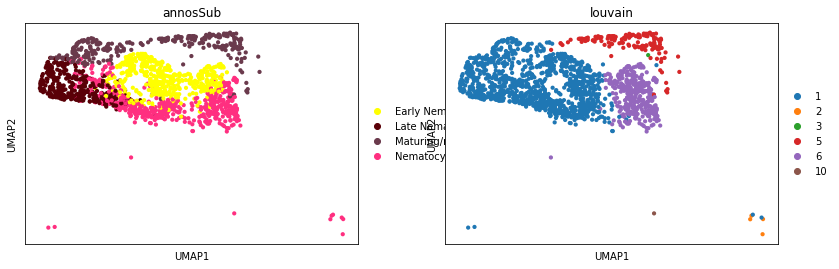

In [200]:
sc.pl.umap(data,color=["annosSub","louvain"])

## Select genes

In [201]:
U = data.layers["unspliced"].toarray()
S = data.layers["spliced"].toarray()
gene_list = select_genes(U,S,data.var_names,mean_min=0.1,var_min=1)
len(gene_list)

31

In [219]:
marker_genes = ['XLOC_044122','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365',
                'XLOC_041836','XLOC_011949','XLOC_015554','XLOC_039385','XLOC_045474',
                'XLOC_004102','XLOC_043404','XLOC_005363','XLOC_039341','XLOC_017845',
                'XLOC_018627','XLOC_011922','XLOC_003773','XLOC_011100','XLOC_019170']
marker_genes = ['XLOC_015554','XLOC_044122','XLOC_045474','XLOC_004102','XLOC_039385','XLOC_011100','XLOC_039341']

In [220]:
fitted_genes_mask = data.var_names.isin(marker_genes) | data.var_names.isin(gene_list)
fitted_genes = data.var_names[fitted_genes_mask]
#sc.pp.highly_variable_genes(data,n_top_genes=100,flavor="seurat_v3")
#fitted_genes_mask = data.var['highly_variable'] & (data.layers['unspliced'].toarray().mean(axis=0)>0.1) & (data.layers['spliced'].toarray().mean(axis=0)>0.1)

X=np.zeros((data.shape[0],np.sum(fitted_genes_mask),2))
X[:,:,0]=data.layers['unspliced'].toarray()[:,fitted_genes_mask]
X[:,:,1]=data.layers['spliced'].toarray()[:,fitted_genes_mask]
X.shape

(1691, 38, 2)

In [221]:
plot_mask = fitted_genes.isin(marker_genes)
plot_idx = np.arange(len(fitted_genes))[plot_mask]
print(fitted_genes[plot_mask])

Index(['XLOC_045474', 'XLOC_044122', 'XLOC_039341', 'XLOC_039385',
       'XLOC_015554', 'XLOC_004102', 'XLOC_011100'],
      dtype='object')


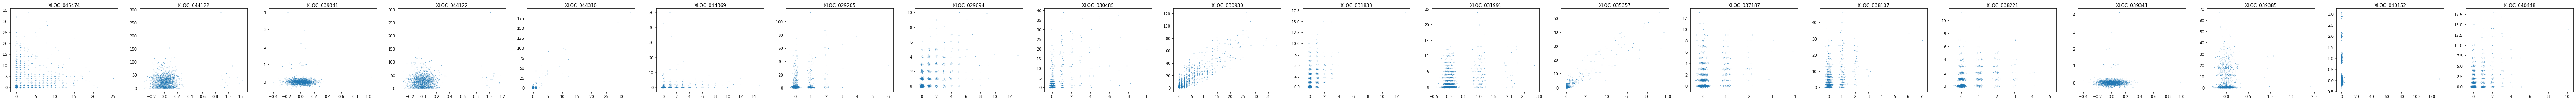

In [222]:
pp = min(20,X.shape[1])
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    if i<3:
        j = plot_idx[i]
    else:
        j = i
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Fitting

In [223]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,epoch=100,n_init=1,parallel=False,n_threads=10,seed=2022)
traj.compute_AIC(X)

run method fit_multi_init
trial 1


 18%|█▊        | 18/100 [00:08<00:40,  2.03it/s]


-399559.0923900319

In [230]:
import itertools
for i,p in enumerate(itertools.permutations(range(3))):
    print(i,p)

0 (0, 1, 2)
1 (0, 2, 1)
2 (1, 0, 2)
3 (1, 2, 0)
4 (2, 0, 1)
5 (2, 1, 0)


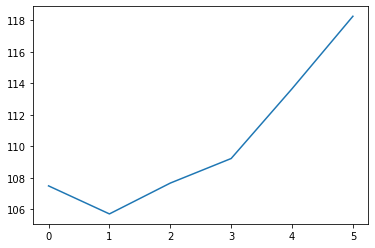

In [231]:
plt.plot(traj.elbos)

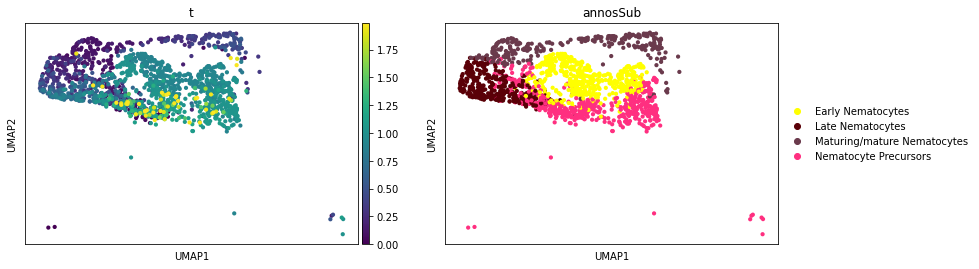

In [232]:
data.obs["t"]=traj.Q[:,0]@traj.t
sc.pl.umap(data,color=["t","annosSub"])

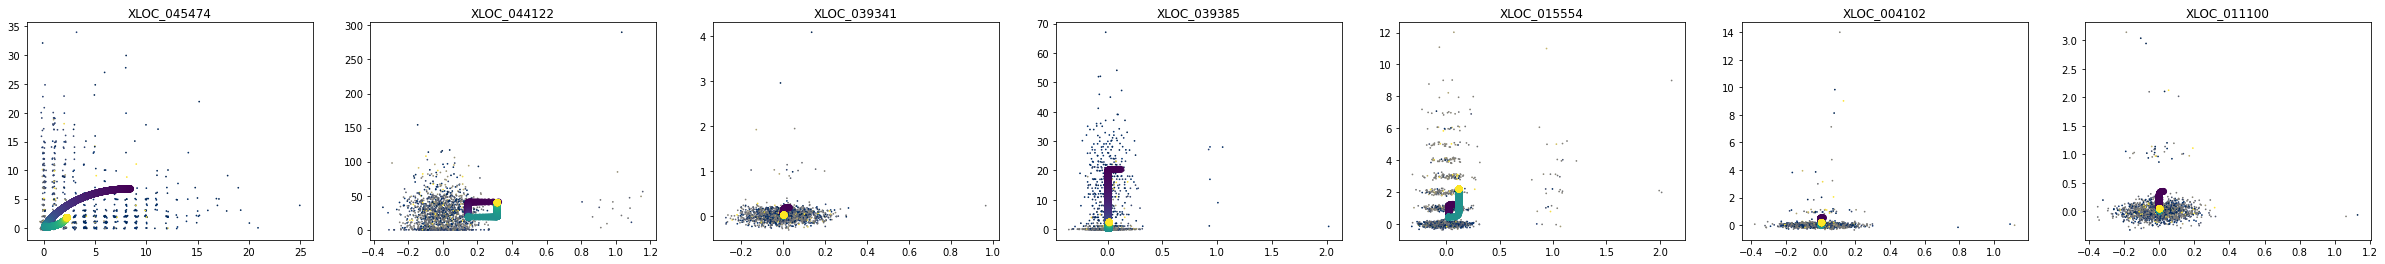

In [233]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

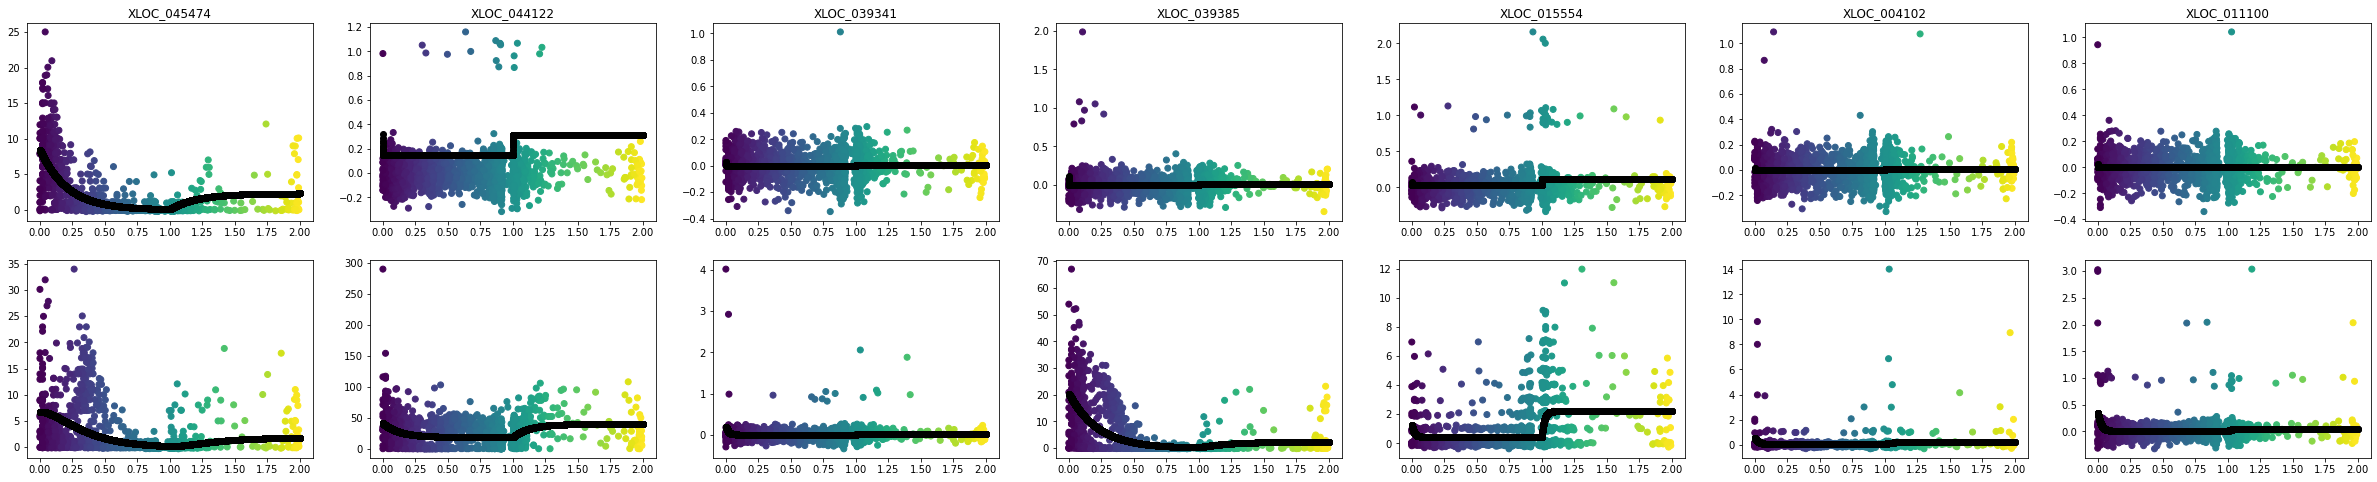

In [234]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes)

In [235]:
traj.theta[plot_idx]

array([[0.00000000e+00, 2.27917030e+00, 8.43873042e+00, 4.81287993e+00,
        5.98624127e+00],
       [1.47861732e-01, 3.15163020e-01, 3.22338867e-01, 1.00000000e+03,
        7.90590772e+00],
       [8.81677845e-04, 2.85846622e-03, 2.89080203e-02, 3.58419984e+02,
        5.60125406e+01],
       [8.30428847e-05, 1.39658538e-02, 1.20212237e-01, 7.68744549e+02,
        4.54141723e+00],
       [2.40977115e-02, 1.20023043e-01, 6.75976770e-02, 1.00000000e+03,
        5.44879250e+01],
       [5.48325689e-04, 5.76266428e-03, 1.64287662e-02, 9.99997292e+02,
        3.08201956e+01],
       [6.90009232e-04, 3.43593949e-03, 2.55914345e-02, 5.72245970e+02,
        4.20051912e+01]])

In [236]:
import copy

traj_ = copy.deepcopy(traj)
#traj_.theta[:,0] = traj.theta[:,1]
#traj_.theta[:,1] = traj.theta[:,0]
m = traj.Q.shape[-1]
mm = m//2
traj_.Q[:,0,mm:] = traj.Q[:,0,:mm]
traj_.Q[:,0,:mm] = traj.Q[:,0,mm:]

In [237]:
traj_ = traj_.fit(X,Q=traj_.Q,epoch=100,parallel=False,n_threads=10)
traj_.compute_AIC(X)

run method fit_warm_start


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


-387195.96670765686

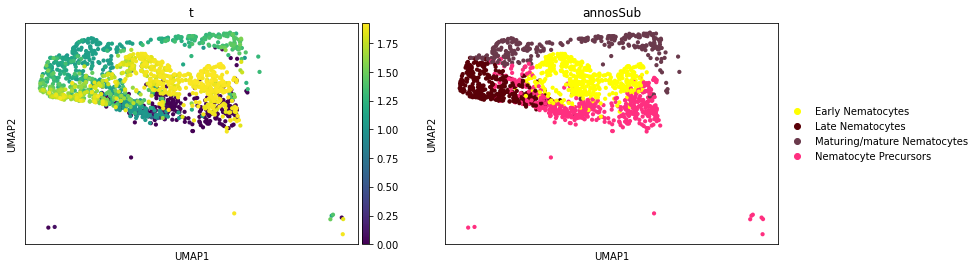

In [238]:
data.obs["t"]=traj_.Q[:,0]@traj.t
sc.pl.umap(data,color=["t","annosSub"])

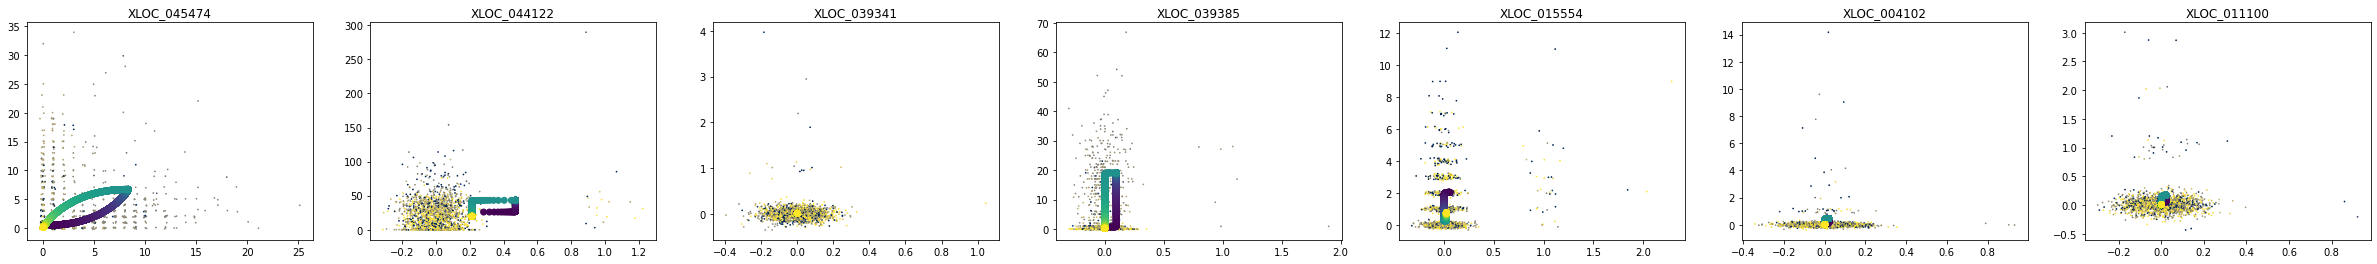

In [239]:
plot_phase(traj_,idx=plot_idx,gene_name=fitted_genes)

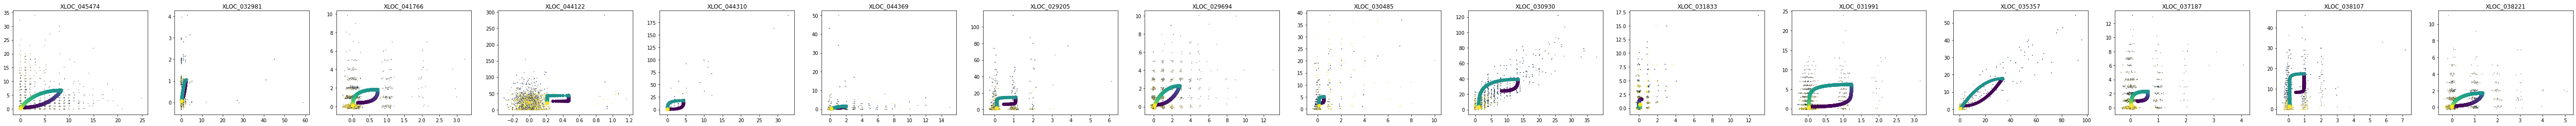

In [240]:
plot_phase(traj_,idx=np.arange(16),gene_name=fitted_genes)

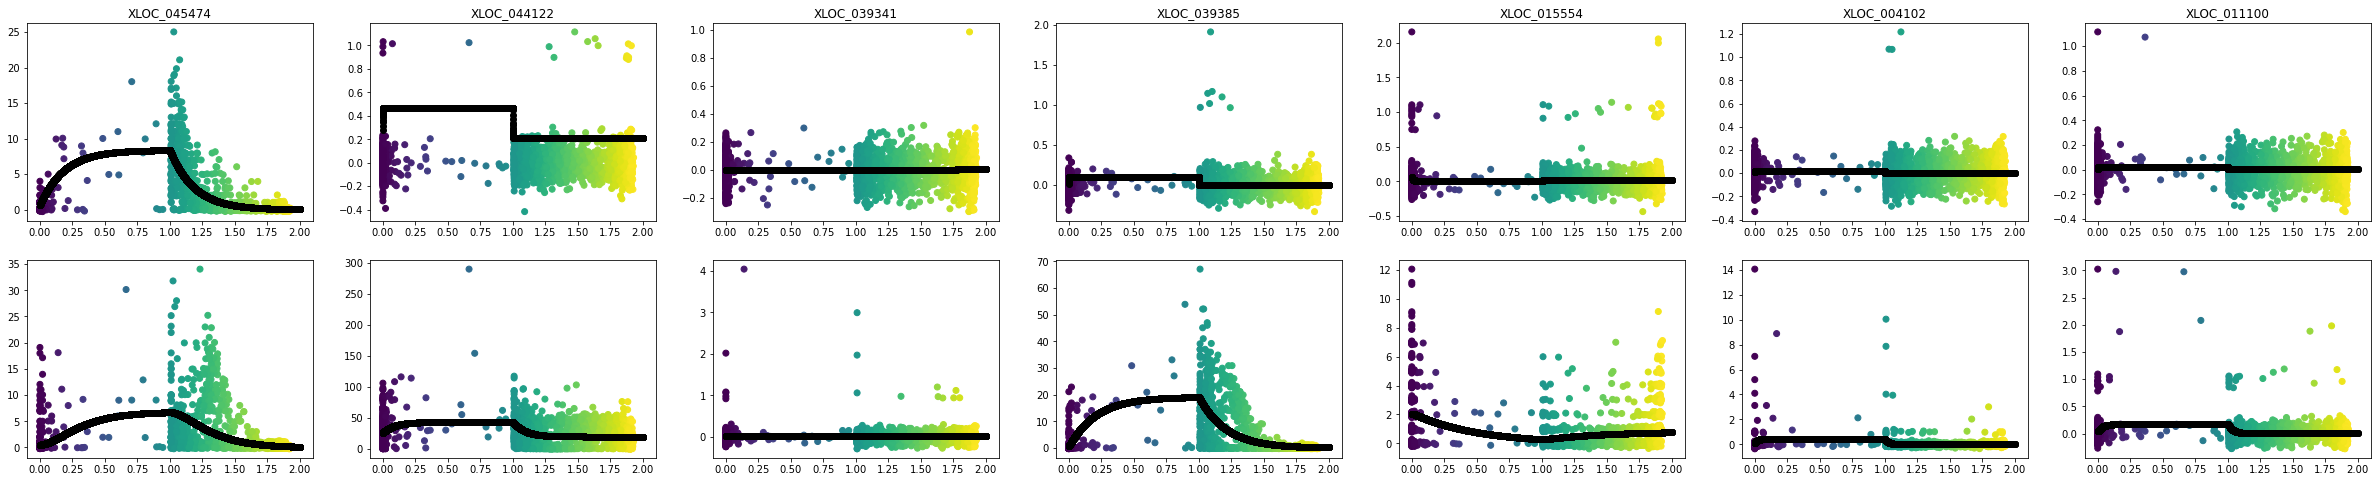

In [241]:
plot_y(traj_,idx=plot_idx,gene_name=fitted_genes)

In [19]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj = Trajectory(topo, tau, model="two_species", verbose=1)
traj = traj.fit(X,n_init=10,epoch=20,parallel=True,n_threads=10)
traj.compute_AIC(X)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]

trial 2



100%|██████████| 20/20 [00:07<00:00,  2.71it/s]

trial 3



 65%|██████▌   | 13/20 [00:05<00:03,  2.23it/s]


KeyboardInterrupt: 

In [ ]:
data.obs["t"]=traj.Q[:,0]@traj.t
sc.pl.umap(data,color=["t","annosSub"])

In [ ]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes)

# Warm start

In [ ]:
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
C =len(celltypes)
for i,celltype in enumerate(celltypes):
    idx = data.obs["annosSub"].isin([celltype])
    weight0[idx,int(i*m/C):int((i+1)*m/C)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
plt.imshow(Q0[:,0],aspect="auto")

In [ ]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj_ = Trajectory(topo, tau, model="two_species_ss", verbose=1)
res = traj_.fit(X,Q=Q0,epoch=20,parallel=True,n_threads=4)

In [ ]:
data.obs["t"]=traj_.Q[:,0]@traj_.t
sc.pl.umap(data,color=["t","annosSub"])

In [ ]:
plot_phase(traj_,idx=plot_idx,gene_name=fitted_genes)

In [ ]:
plot_y(traj_,idx=plot_idx,gene_name=fitted_genes)